<a href="https://colab.research.google.com/github/arko-sys/XAI-Explainable-Deep-Learning/blob/main/Explainable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install grad-cam

In [2]:

import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from google.colab import drive
import requests
from io import BytesIO
from PIL import Image
import random

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

## Loading Dataset

In [3]:
import kagglehub
import os

path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'animal-image-dataset-90-different-animals' dataset.
Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [4]:
!ls /root/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5/animals/animals

antelope     crab	goose	      leopard	 parrot		 sheep
badger	     crow	gorilla       lion	 pelecaniformes  snake
bat	     deer	grasshopper   lizard	 penguin	 sparrow
bear	     dog	hamster       lobster	 pig		 squid
bee	     dolphin	hare	      mosquito	 pigeon		 squirrel
beetle	     donkey	hedgehog      moth	 porcupine	 starfish
bison	     dragonfly	hippopotamus  mouse	 possum		 swan
boar	     duck	hornbill      octopus	 raccoon	 tiger
butterfly    eagle	horse	      okapi	 rat		 turkey
cat	     elephant	hummingbird   orangutan  reindeer	 turtle
caterpillar  flamingo	hyena	      otter	 rhinoceros	 whale
chimpanzee   fly	jellyfish     owl	 sandpiper	 wolf
cockroach    fox	kangaroo      ox	 seahorse	 wombat
cow	     goat	koala	      oyster	 seal		 woodpecker
coyote	     goldfish	ladybugs      panda	 shark		 zebra


In [5]:


# Base path to dataset
base_path = "/root/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5/animals/animals"

def create_sample_dataset(base_path, num_classes=5, seed=44):

    random.seed(seed)

    # Get available animal folders
    animal_folders = [
        d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))
    ]

    # Select first `num_classes` folders
    selected_folders = animal_folders[:num_classes]

    # Dictionary to hold sample dataset
    sample_dataset = {}

    for animal in selected_folders:
        animal_path = os.path.join(base_path, animal)

        # Filter only .jpg files
        image_files = [
            f for f in os.listdir(animal_path)
            if f.lower().endswith(".jpg") and os.path.isfile(os.path.join(animal_path, f))
        ]

        if image_files:
            random_image_file = random.choice(image_files)
            sample_image_path = os.path.join(animal_path, random_image_file)
            try:
                img = Image.open(sample_image_path).convert("RGB")
                sample_dataset[animal] = img
                print(f"Loaded {animal}: {random_image_file}")
            except Exception as e:
                print(f"Error loading {animal}: {e}")
        else:
            print(f"No .jpg images found for {animal}")

    return sample_dataset




Loaded lobster: 12120b160e.jpg
Loaded panda: 4f4b18c73f.jpg
Loaded pig: 18cd745630.jpg
Loaded dolphin: 7f653cb2fc.jpg
Loaded goldfish: 6f861b40ef.jpg


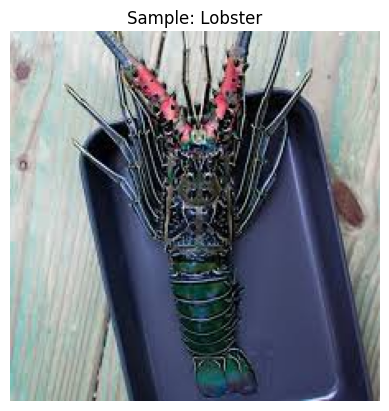

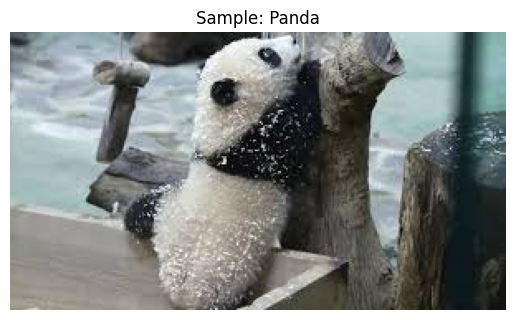

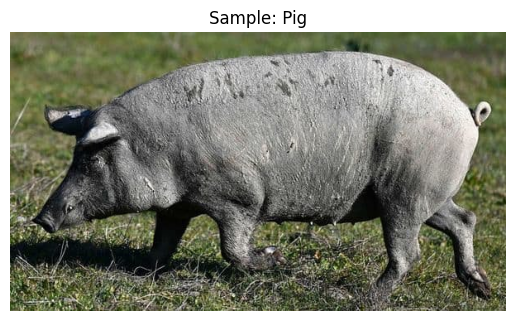

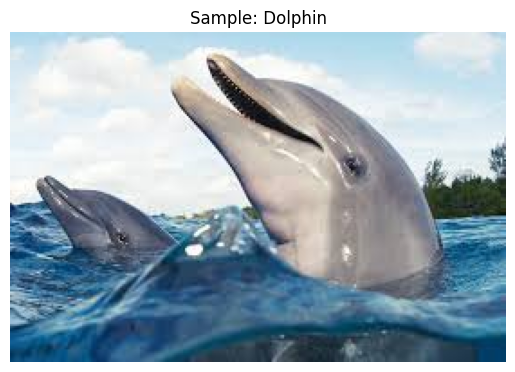

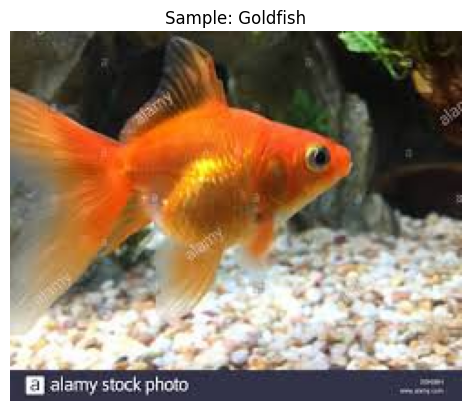

In [6]:
sample_dataset = create_sample_dataset(base_path, num_classes=5)

# Display samples
for animal, img in sample_dataset.items():
    plt.imshow(img)
    plt.title(f"Sample: {animal.capitalize()}")
    plt.axis("off")
    plt.show()

## Loading pretrained model (resnet50)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model = models.resnet50(pretrained=True).to(device)
model.eval()
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Applying GradCAM variations to last convolutional block

In [10]:
target_layer = model.layer4[-1]
cam_methods = {
    "GradCAM": GradCAM(model=model, target_layers=[target_layer]),
    "GradCAM++": GradCAMPlusPlus(model=model, target_layers=[target_layer]),
    "ScoreCAM": ScoreCAM(model=model, target_layers=[target_layer])
    }

100%|██████████| 128/128 [00:08<00:00, 15.31it/s]


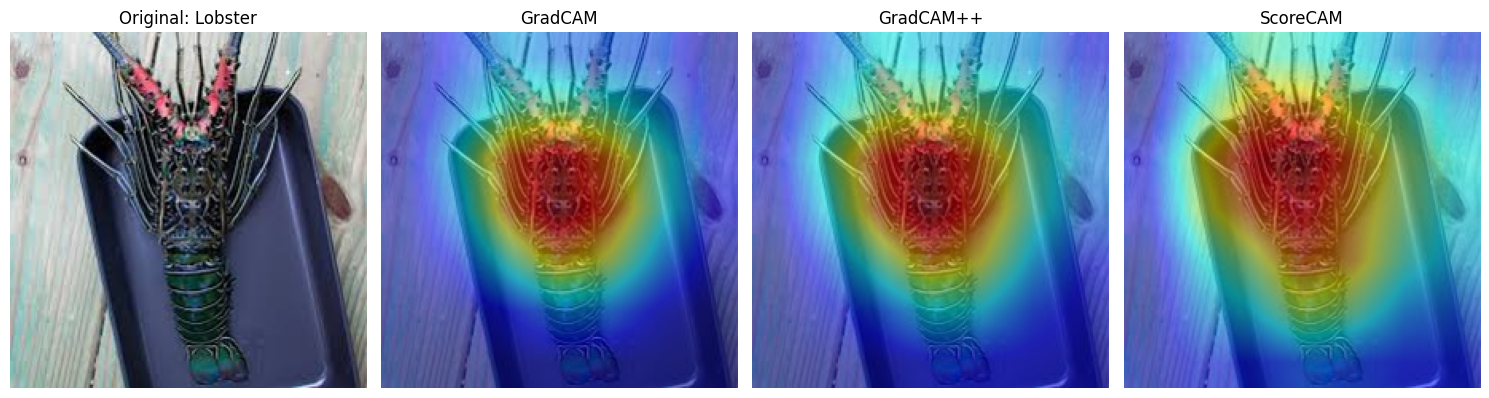

100%|██████████| 128/128 [00:07<00:00, 17.49it/s]


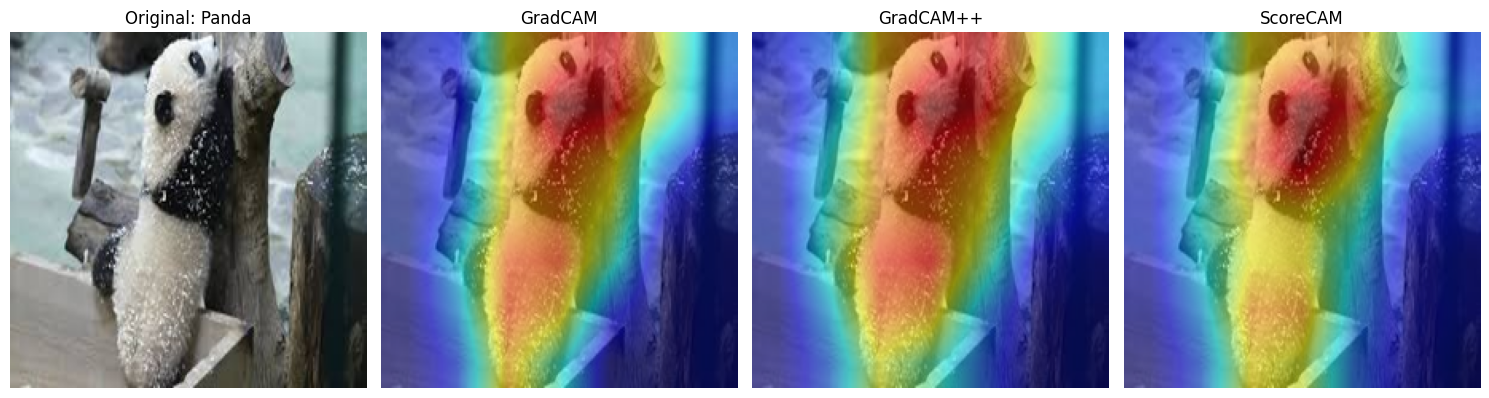

100%|██████████| 128/128 [00:07<00:00, 16.24it/s]


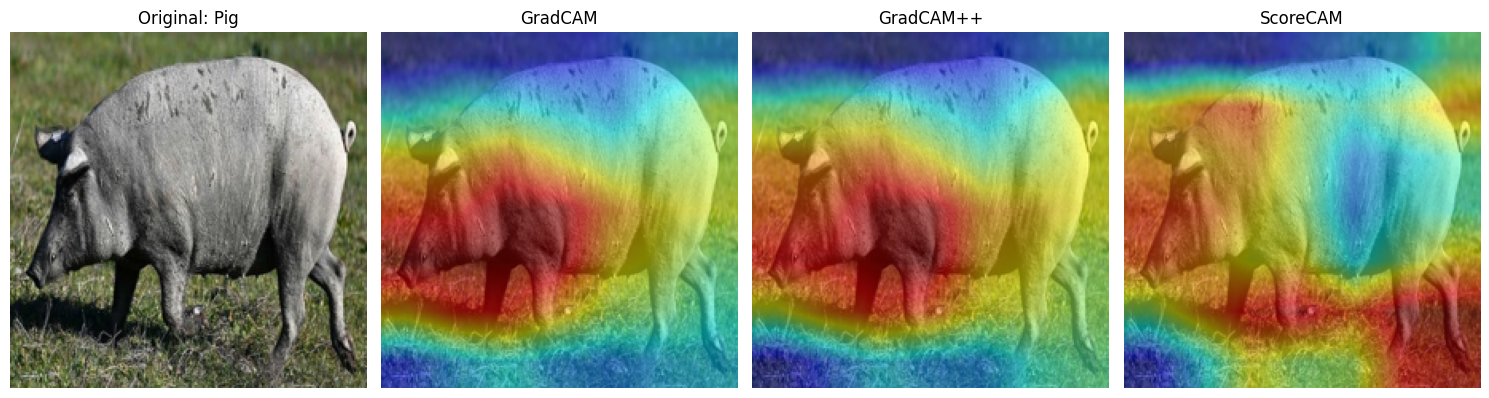

100%|██████████| 128/128 [00:07<00:00, 18.10it/s]


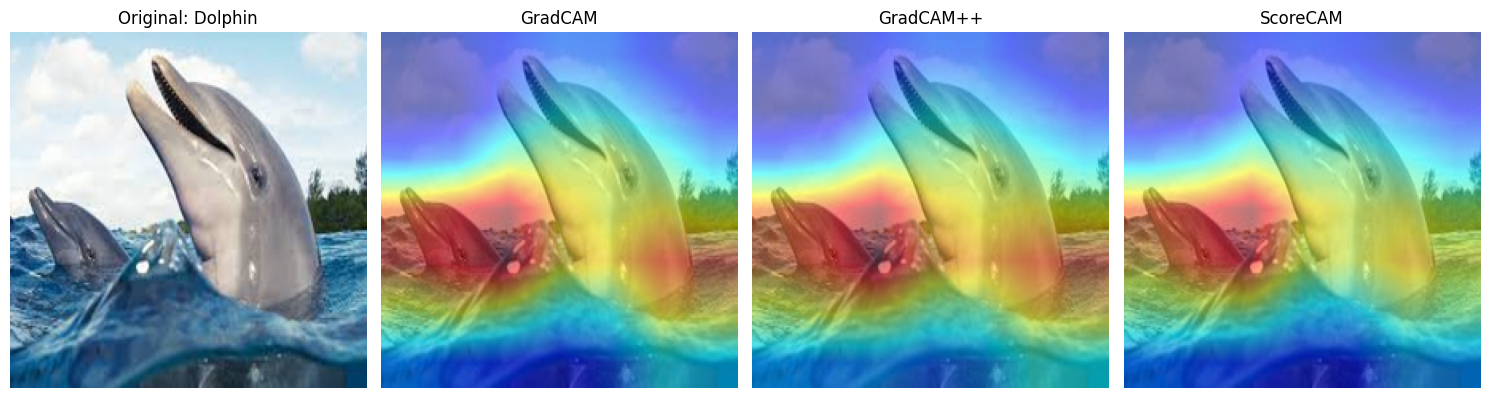

100%|██████████| 128/128 [00:06<00:00, 18.81it/s]


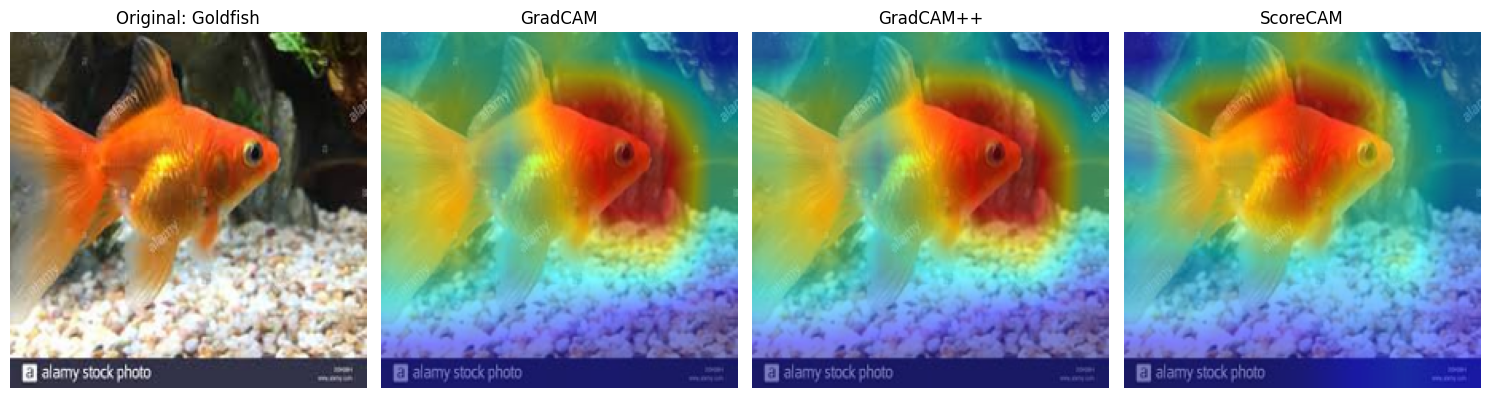

In [11]:
os.makedirs("cam_outputs", exist_ok=True)

for animal, img in sample_dataset.items():
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
    probabilities = F.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    targets = [ClassifierOutputTarget(predicted_class)]

    # Convert original image to numpy (resize to 224x224 for consistency)
    img_resized = img.resize((224, 224))
    rgb_img = np.float32(np.array(img_resized)) / 255.0

    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(cam_methods) + 1, 1)
    plt.imshow(rgb_img)
    plt.title(f"Original: {animal.capitalize()}")
    plt.axis('off')

    for i, (cam_name, cam_method) in enumerate(cam_methods.items()):
        grayscale_cam = cam_method(input_tensor=input_tensor, targets=targets)[0, :]
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        plt.subplot(1, len(cam_methods) + 1, i + 2)
        plt.imshow(cam_image)
        plt.title(f"{cam_name}")
        plt.axis('off')

    plt.tight_layout()

    save_path = os.path.join("cam_outputs", f"{animal}_cams.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

The comparative analysis of GradCAM, GradCAM++, and ScoreCAM reveals both the strengths and limitations of these explainability methods when applied to animal classification tasks.

GradCAM produces relatively coarse heatmaps that capture the most salient discriminative regions of an image, such as the dolphin's head or the panda's torso. While these visualizations are useful in highlighting the dominant cues driving classification, they often lack granularity, sometimes extending attention into non-essential or background areas.

GradCAM++, in contrast, offers sharper and more localized attention maps. By considering higher order derivatives, it can identify multiple important regions, such as the goldfish's fins in addition to its head. However, this increased sensitivity can introduce noise, occasionally highlighting peripheral features.

ScoreCAM differs by producing smoother, more holistic attention maps that encompass the entire object ... such as the full body of a pig or panda ... providing a representation that aligns more closely with human visual intuition, albeit at a considerably higher computational cost.





These methods also reveal surprising and, at times, problematic model behaviors. For example, in several cases, attention extended beyond the animal to contextual elements, such as the grassy background in the pig image or the climbing pole in the panda example. This suggests that the model may be partially relying on environmental correlations rather than exclusively focusing on the object itself. Similarly, the lobster visualization demonstrates a strong bias toward the claws, likely driven by their vivid color contrast, which may not generalize well across varying contexts. These tendencies highlight the risk of spurious associations and raise questions about the robustness of the learned representations.

The importance of explainability in this domain is essential. It allows researchers to verify whether models are learning meaningful features or overfitting to spurious correlations, facilitates transparent communication of model behavior to stakeholders in sensitive areas like conservation, and provides complementary perspectives through different CAM variants—GradCAM for broad cues, GradCAM++ for fine detail, and ScoreCAM for holistic coherence. Together, these tools highlight the need for multiple interpretability methods to ensure computer vision systems are reliable and trustworthy.
